# Mixture Models

We are given a set of 200 data points which appear to come from a mixture of Gaussian distributions. Objective is to find the coefficients of the mixture model.

We follow the modeling strategy outlined in the paper [An introduction to data analysis using the PyMC3 probabilistic programming framework: A case study with Gaussian Mixture Modeling](https://psyarxiv.com/aes5f/download/?format=pdf) (Liew, et al, 2019), which is analogous to the approach followed with JAGS in the course video.

Other of PyMC3 usage with Hierarchical models can be found in the links below.

* [PyMC3 documentation for Mixture](https://docs.pymc.io/api/distributions/mixture.html) -- shows multiple strategies for defining mixture models with PyMC3.
* [Dirichlet Process Mixture for Density Estimation](https://docs.pymc.io/notebooks/dp_mix.html) -- similar to the example in the course.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy.stats as stats
import statsmodels.api as sm
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore")

## Generate Data

The course provides a `mixture.csv` file which contains a single column of data points drawn from two Gaussian distributions. Ordinarily I would want to keep a local copy, but it is fairly simple to generate your own dataset using the strategy below, so I will do that instead.

We want to sample data from two distributions, with different probabilities of sampling from one or the other. The probabilities must add up to 1.

In [3]:
p = [0.4, 0.6]
dist_1 = stats.norm.rvs(loc=-2.5, scale=1, size=int(500 * p[0]))
dist_2 = stats.norm.rvs(loc=1.5, scale=1, size=int(500 * p[1]))

data = []
data.extend([(1, d) for d in dist_1])
data.extend([(2, d) for d in dist_2])

In [4]:
gen_df = pd.DataFrame(data, columns=["d", "v"])
gen_df.head()

,d,v
0,1,-1.598911
1,1,-2.744256
2,1,-1.704290
3,1,-3.816670
4,1,-2.557289


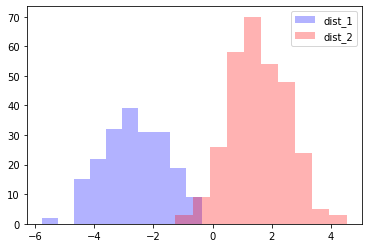

In [5]:
plt.hist(gen_df[gen_df["d"]==1]["v"].values, color="b", alpha=0.3, label="dist_1")
plt.hist(gen_df[gen_df["d"]==2]["v"].values, color="r", alpha=0.3, label="dist_2")
plt.legend(loc="best")
_ = plt.show()

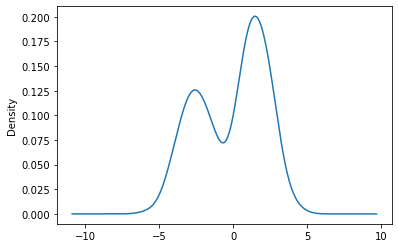

In [6]:
_ = gen_df["v"].plot.density()

## Define Model

When solving for the model, we don't have access to which distribution each sample came from. Based on the density plot above, we can hypothesize that the sample data comes from a mixture of 2 normal distributions. We assume a hidden categorical variable z which will determine which distribution this will come from, and a variable $\omega$ that specifies the probability distribution of the z values.

For $\mu_k$ below, we hypothesize that one of the distributions has a mean around -1 and the other has a mean of around +1.

$$ \omega \sim Dirichlet(a=[1, 1]) $$
$$ z_i \mid \omega_k \sim Categorical(\omega) $$
$$ \mu_k \sim Normal(\mu=[-1,1], \sigma=1e2) $$
$$ \tau_k \sim InverseGamma(\alpha=0.5, \beta=0.5) $$
$$ y_i \mid z_i=k \sim Normal(\mu_k, \sqrt{\tau_k}) $$

Our objective here is to retrieve the parameters from the model, and compare them to the values we already know from above.

From the summary of the trace, we have the following findings:

* First Distribution is `Normal(mu=-2.4, sigma=1.05)` which is close to our input `Normal(-2.5, 1)`.
* Second Distribution is `Normal(mu=1.6, sigma=0.869)` which is close to our input `Normal(1.5, 1)`.
* Distribution mixture is `[0.405, 0.595]` which is close to our input `[0.4, 0.6]`.

In [7]:
k = 2   # number of distributions

y = gen_df["v"].values
y.shape

(500,)

In [8]:
model_1 = pm.Model()
with model_1:

    omega = pm.Dirichlet("omega", a=np.array([1] * k))
    z = pm.Categorical("z", p=omega, shape=len(y))
    
    mu1 = pm.Normal("mu1", mu=-1.0, sigma=1e2)
    mu2 = pm.Normal("mu2", mu=1.0, sigma=1e2)
    mus = pm.math.stack([mu1, mu2])
    
    tau = pm.InverseGamma("tau", alpha=0.5, beta=0.5, shape=k)
    sig = pm.math.sqrt(tau)

    y_obs = pm.Normal("y_obs", mu=mus[z], sd=sig[z], observed=y)
    
    trace_1 = pm.sample(5000, tune=1000)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [tau, mu2, mu1, omega]
>BinaryGibbsMetropolis: [z]
Sampling 4 chains, 0 divergences: 100%|██████████| 24000/24000 [06:00<00:00, 66.52draws/s]
The number of effective samples is smaller than 25% for some parameters.


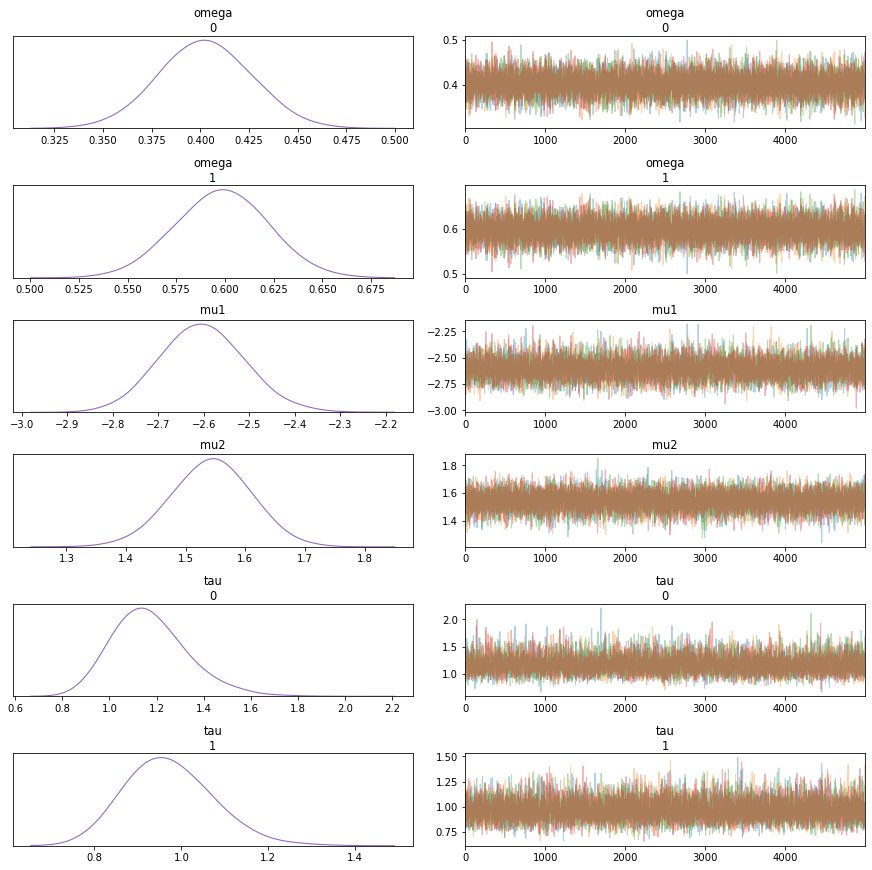

In [9]:
_ = pm.traceplot(trace_1, varnames=["omega", "mu1", "mu2", "tau"], combined=True, compact=False)

In [10]:
pm.summary(trace_1, var_names=["omega", "mu1", "mu2", "tau"])

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
omega[0],0.402,0.024,0.358,0.447,0.000,0.000,11071.0,11048.0,11072.0,13744.0,1.0
omega[1],0.598,0.024,0.553,0.642,0.000,0.000,11071.0,11069.0,11072.0,13744.0,1.0
mu1,-2.605,0.093,-2.778,-2.429,0.001,0.001,8118.0,8118.0,8210.0,10118.0,1.0
mu2,1.542,0.066,1.420,1.669,0.001,0.000,10134.0,10134.0,10175.0,12627.0,1.0
tau[0],1.171,0.160,0.888,1.477,0.002,0.001,6728.0,6641.0,6966.0,10916.0,1.0
tau[1],0.971,0.102,0.777,1.155,0.001,0.001,8497.0,8419.0,8648.0,11383.0,1.0


## Look at some posterior distributions for z

In [11]:
summary_df = pm.summary(trace_1)

In [12]:
summary_df.loc[["z[1]"]]

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
z[1],0.0,0.017,0.0,0.0,0.0,0.0,20023.0,20023.0,20023.0,20023.0,1.0


In [13]:
summary_df.loc[["z[31]"]]

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
z[31],0.0,0.0,0.0,0.0,0.0,0.0,20000.0,20000.0,20000.0,20000.0,NaN


In [14]:
summary_df.loc[["z[350]"]]

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
z[350],1.0,0.007,1.0,1.0,0.0,0.0,20016.0,20016.0,20016.0,20000.0,1.0


In [15]:
summary_df.loc[["z[470]"]]

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
z[470],1.0,0.0,1.0,1.0,0.0,0.0,20000.0,20000.0,20000.0,20000.0,NaN


In [16]:
z = trace_1.get_values("z")

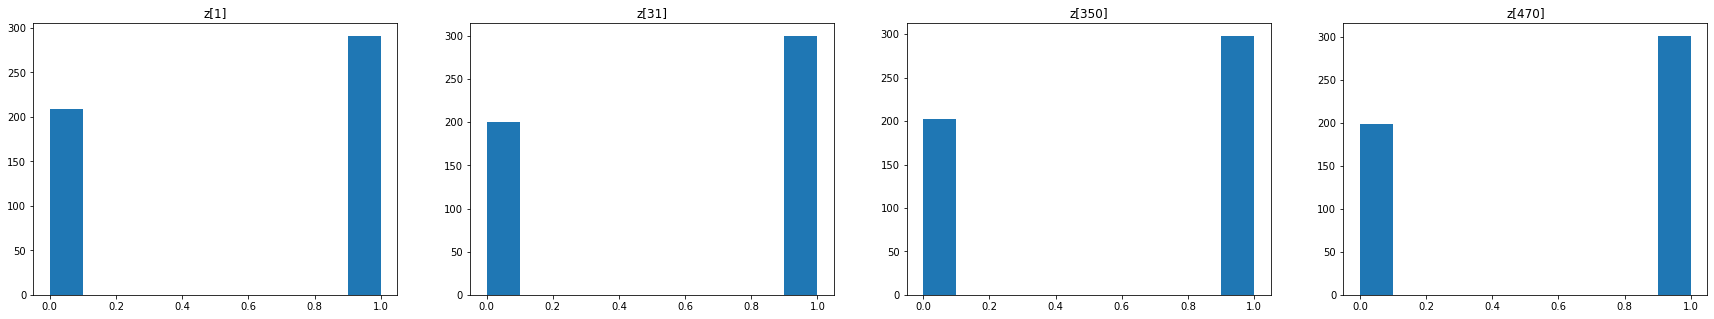

In [17]:
plt.figure(figsize=(30, 5))

plt.subplot(141)
plt.hist(z[1])
plt.title("z[1]")

plt.subplot(142)
plt.hist(z[31])
plt.title("z[31]")

plt.subplot(143)
plt.hist(z[350])
plt.title("z[350]")

plt.subplot(144)
plt.hist(z[470])
plt.title("z[470]")

_ = plt.show()